# Step 0: Dataset
https://www.kaggle.com/datasets/koryakinp/chess-positions

About Dataset
Context

The goal of the project is to build a model able to generate FEN description based on a schematic image of a chess board.
Content

100000 images of a randomly generated chess positions of 5-15 pieces (2 kings and 3-13 pawns/pieces) Images were generated using 28 styles of chess boards and 32 styles of chess pieces totaling 896 board/piece style combinations.

Images were generated using this custom-build tool

All images are 400 by 400 pixels.

    Training set: 80000 images
    Test set: 20000 images

Pieces were generated with the following probability distribution:

    30% for Pawn
    20% for Bishop
    20% for Knight
    20% for Rook
    10% for Queen

2 Kings are guaranteed to be on the board.

Labels are in a filename in Forsyth–Edwards Notation format, but with dashes instead of slashes.
Acknowledgements

Chess.com for providing images of pieces and boards.
Note

Some positions may be illegal such as both kings are under check.

# Step 1: Dependencies

In [1]:
# ===========================
# Cell 1: Imports
# ===========================

import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import random




# Step 2: Load data

In [2]:
# ===========================
# Cell 2: Dataset pipeline with image count
# ===========================
data_dir = Path("data/train")  # Reference images folder

def parse_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256]) / 255.0
    filename = tf.strings.split(file_path, os.sep)[-1]
    return img, filename

# List all image paths
file_paths = list(data_dir.rglob("*.jpg")) + list(data_dir.rglob("*.jpeg")) + list(data_dir.rglob("*.png"))
file_paths = [str(p) for p in file_paths]

# Print number of images found
print(f"Found {len(file_paths)} images in {data_dir}")

# Create tf.data.Dataset with parallel mapping, batching, and prefetching
dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(128).prefetch(tf.data.AUTOTUNE)


Found 80000 images in data\train


In [3]:
# ===========================
# Cell 3: Create embedding model
# ===========================

def create_embedding_model(input_shape=(256,256,3), embedding_dim=256):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)  # L2 normalize
    return models.Model(inputs, x)

embedding_model = create_embedding_model()
embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,272 (493.25 KB)

 Trainable params: 126,272 (493.25 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# ===========================
# Cell 4: Compute reference embeddings (with progress)
# ===========================
# Using model.predict(verbose=1) for live progress in Jupyter

reference_embeddings = embedding_model.predict(dataset, verbose=1)

# Collect filenames in the same order
filenames = []
for _, label_batch in dataset:
    filenames.extend([s.numpy().decode() for s in label_batch])

print("Reference embeddings shape:", reference_embeddings.shape)
print("Number of filenames:", len(filenames))

# Save embeddings for future use
np.save("reference_embeddings.npy", reference_embeddings)
np.save("filenames.npy", filenames)


625/625 ━━━━━━━━━━━━━━━━━━━━ 328s 524ms/step
Reference embeddings shape: (80000, 256)
Number of filenames: 80000


In [5]:
# ===========================
# Cell 5: Load saved embeddings (optional)
# ===========================
reference_embeddings = np.load("reference_embeddings.npy")
filenames = np.load("filenames.npy", allow_pickle=True).tolist()


In [6]:
# ===========================
# Cell 6: Function to predict nearest filename
# ===========================
def predict_filename(new_image, reference_embeddings, filenames, embedding_model):
    """
    Predict the filename of the most similar image in reference_embeddings.
    """
    emb = embedding_model(np.expand_dims(new_image, axis=0)).numpy()
    sims = np.dot(reference_embeddings, emb.T).squeeze()  # cosine similarity
    idx = np.argmax(sims)
    return filenames[idx]


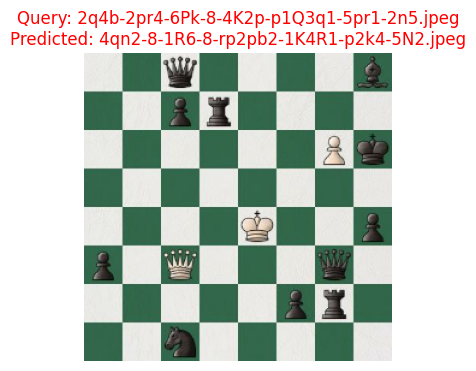

Top-5 predicted filenames:
1. 4qn2-8-1R6-8-rp2pb2-1K4R1-p2k4-5N2.jpeg
2. 4B1k1-1r4N1-3B1K2-8-8-3b1P2-p3r3-b7.jpeg
3. 8-4NB2-8-1K3p2-2qR3b-6r1-3B4-2kR4.jpeg
4. 7k-5q2-8-P1rq4-2Q5-nrr1P3-5K2-2Q5.jpeg
5. 3n4-1B3N2-2P1p3-5b2-1r1p1K1q-8-2b5-2Q3k1.jpeg


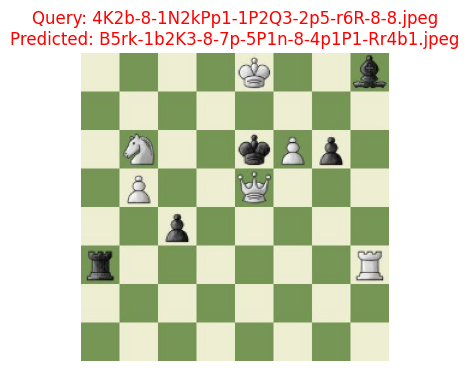

Top-5 predicted filenames:
1. B5rk-1b2K3-8-7p-5P1n-8-4p1P1-Rr4b1.jpeg
2. 2Q2n1Q-8-8-1K1pkr2-5b2-8-7r-B1R4q.jpeg
3. N7-5N1n-1P6-5rk1-3K4-8-b2NQ3-8.jpeg
4. 3B4-1rQ5-4k3-4b3-P1K2p1P-2B5-8-8.jpeg
5. 3N3k-3r4-KB6-P1B5-2n3R1-7P-5n2-r7.jpeg


In [14]:
# ===========================
# Cell 7: Top-5 nearest filename predictions with color-coded title
# ===========================
import random
from matplotlib import pyplot as plt

test_dir = Path("data/test")
test_files = list(test_dir.rglob("*.jpg")) + list(test_dir.rglob("*.jpeg")) + list(test_dir.rglob("*.png"))

# Shuffle test files and optionally limit for speed
random.shuffle(test_files)
N = 2  # number of test images to display
test_files = test_files[:N]

for file_path in test_files:
    # Load and preprocess image
    img = tf.io.read_file(str(file_path))
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, [256, 256]) / 255.0
    img_input = img_resized.numpy()

    # Compute embedding
    emb = embedding_model(np.expand_dims(img_input, axis=0)).numpy()

    # Compute cosine similarities
    sims = np.dot(reference_embeddings, emb.T).squeeze()
    top5_idx = sims.argsort()[-5:][::-1]  # indices of top-5 closest embeddings
    top5_filenames = [filenames[i] for i in top5_idx]

    actual_filename = file_path.name

    # Determine title color based on top-1 prediction
    title_color = "green" if top5_filenames[0] == actual_filename else "red"

    # Display the query image
    plt.figure(figsize=(4,4))
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title(f"Query: {file_path.name}\nPredicted: {top5_filenames[0]}", color=title_color)
    plt.show()

    # Print top-5 predicted filenames
    print("Top-5 predicted filenames:")
    for rank, fname in enumerate(top5_filenames, 1):
        print(f"{rank}. {fname}")


In [26]:
# ===========================
# Cell 8: Compute Top-1 / Top-5 retrieval accuracy
# ===========================
import random
from tqdm.notebook import tqdm

test_dir = Path("data/test")
test_files = list(test_dir.rglob("*.jpg")) + list(test_dir.rglob("*.jpeg")) + list(test_dir.rglob("*.png"))

# Shuffle test files
random.shuffle(test_files)

# Limit number of test images for speed (optional)
N = 100  # change as needed
test_files = test_files[:N]

top1_correct = 0
top5_correct = 0

for file_path in tqdm(test_files, desc="Evaluating retrieval"):
    # Load and preprocess image
    img = tf.io.read_file(str(file_path))
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, [256, 256]) / 255.0
    img_input = img_resized.numpy()

    # Compute embedding
    emb = embedding_model(np.expand_dims(img_input, axis=0)).numpy()

    # Compute cosine similarities
    sims = np.dot(reference_embeddings, emb.T).squeeze()
    top5_idx = sims.argsort()[-5:][::-1]  # indices of top-5 closest embeddings
    top5_filenames = [filenames[i] for i in top5_idx]

    actual_filename = file_path.name

    # Check top-1 and top-5
    if top5_filenames[0] == actual_filename:
        top1_correct += 1
    if actual_filename in top5_filenames:
        top5_correct += 1

# Compute accuracy
top1_accuracy = top1_correct / len(test_files)
top5_accuracy = top5_correct / len(test_files)

print(f"Tested {len(test_files)} images")
print(f"Top-1 accuracy: {top1_accuracy*100:.2f}%")
print(f"Top-5 accuracy: {top5_accuracy*100:.2f}%")


Evaluating retrieval:   0%|          | 0/100 [00:00<?, ?it/s]

Tested 100 images
Top-1 accuracy: 0.00%
Top-5 accuracy: 0.00%
